In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
from networkx.generators.classic import star_graph

import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit

import numpy as np

Per via di problemi dovuti alle versioni delle librerie di networkx installate abbiamo aggiunto la funzione della libreria nel file per poterla usare senza preoccuparci delle versioni. La funzione originale può essere trovata nella documentazione della libreria al link https://networkx.org/documentation/stable/_modules/networkx/generators/random_graphs.html#barabasi_albert_graph

In [2]:
@py_random_state(2)
def barabasi_albert(n, m, seed=None, initial_graph=None):
    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        G = star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    source = len(G)
    while source < n:
        targets = _random_subset(repeated_nodes, m, seed)
        G.add_edges_from(zip([source] * m, targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)

        source += 1
    return G

## Tasso di crescita

Scale-free

In [3]:
N = int(1e4)
M = 4

N0 = 20

In [4]:
nodes = [20, 120, 250]

In [5]:
BA = barabasi_albert(N0, M)
k_i=[[]]
I = []

for x in range(N0):
    if x in nodes:
        I += [x]
        k_i += [[]]
        
for n in range(21, N):
    BA = barabasi_albert(n, M, initial_graph = BA)
    if n-1 in nodes:
        I += [n-1]
        k_i += [[]]
        
    iter = 0
    for i in I:
        k_i[iter] += [[n, BA.degree[i]]]
        iter += 1

fit for node 20 is 2.300360860396255*(t/t_i)^0.5551057562123817
fit for node 120 is 4.399160932598626*(t/t_i)^0.4366949258846029
fit for node 250 is 6.192414514174945*(t/t_i)^0.3525812629521202


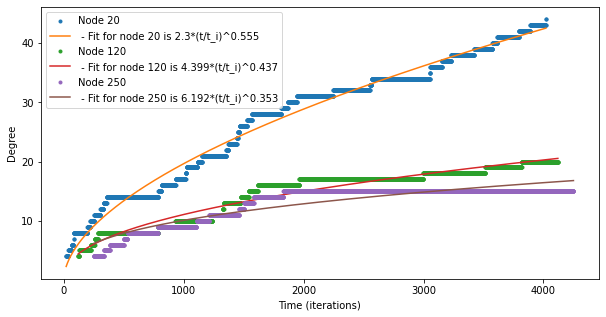

In [6]:
def degree_growth_rate(x, m, a):
    return m*np.power(x, a)

popt = [0]*len(nodes)
pcov = [0]*len(nodes)

fig, ax = plt.subplots(figsize = (10, 5))

for i in range(len(nodes)):
    x = [time for time, k in k_i[i]][:4000]
    y = [k for time, k in k_i[i]][:4000]
    
    plt.plot(x, y, '.', label = f"Node {nodes[i]}")
    
    popt[i], pcov[i] = curve_fit(degree_growth_rate, [xi/x[0] for xi in x], y)
    plt.plot(x, degree_growth_rate([xi/x[0] for xi in x], *popt[i]), '-', 
             label = f" - Fit for node {nodes[i]} is {np.round(popt[i][0], 3)}*(t/t_i)^{np.round(popt[i][1], 3)}")
    print(f"fit for node {nodes[i]} is {popt[i][0]}*(t/t_i)^{popt[i][1]}")
#     print(stats.chisquare(y, degree_growth_rate(x, *popt[i])))

ax.set_xlabel("Time (iterations)")
ax.set_ylabel("Degree")
ax.legend()

# plt.xscale('log')
# plt.yscale('log')

plt.show()

## Average path lenght

In [8]:
N = [10+i*100 for i in range(30)]
M = 3
P = 0.5

mean_path_scalefree = []
mean_path_random = []
max_degree_scalefree = []
max_degree_random = []
diameter_scalefree = []
diameter_random = []

Gb = nx.complete_graph(M)

for i in range(len(N)):
    Ge = nx.erdos_renyi_graph(N[i], P)
    while min([d for n, d in Ge.degree()]) == 0:
        Ge = nx.erdos_renyi_graph(N[i], P)
            
    Gb = nx.barabasi_albert_graph(N[i], M, initial_graph = Gb)

    mean_path_scalefree += [nx.average_shortest_path_length(Gb)]  
    mean_path_random += [nx.average_shortest_path_length(Ge)] 
    
    max_degree_scalefree += [max([d for n,d in Gb.degree])]
    max_degree_random += [max([d for n,d in Ge.degree])]
    
    diameter_scalefree += [nx.diameter(Gb)]
    diameter_random += [nx.diameter(Ge)]

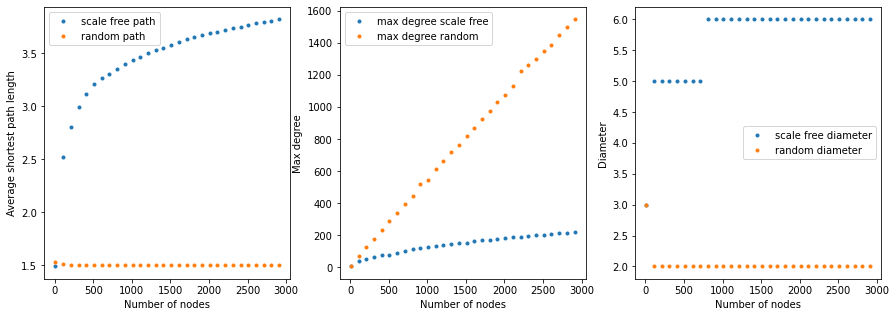

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

ax[0].plot(N, mean_path_scalefree, '.', label = 'scale free path')
ax[0].plot(N, mean_path_random, '.', label = 'random path')

ax[1].plot(N, max_degree_scalefree, '.', label = 'max degree scale free')
ax[1].plot(N, max_degree_random, '.', label = 'max degree random')

ax[2].plot(N, diameter_scalefree, '.', label = 'scale free diameter')
ax[2].plot(N, diameter_random, '.', label = 'random diameter')

ax[0].set_ylabel("Average shortest path length") 
ax[1].set_ylabel("Max degree") 
ax[2].set_ylabel("Diameter")

for i in range(len(ax)):
    ax[i].set_xlabel("Number of nodes")
    ax[i].legend()

plt.show()

Scale free fit parameters: [2.87800375 0.54480118] ∓ [0.12533235 0.00578347]


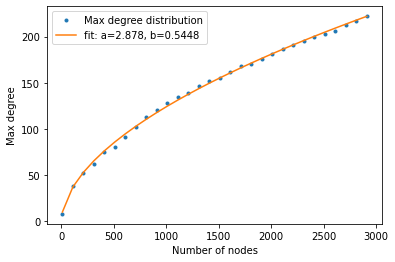

In [12]:
def sqrt_law(x, a, b):
    return a*np.power(x, b)

def log_law(x, a):
    return a*np.log(x)

poptSF, pcovSF = curve_fit(sqrt_law, N, max_degree_scalefree)
# poptR, pcovR = curve_fit(log_law, N, max_degree_random)
# random_fit = np.polyfit(N, max_degree_random, 1)

perrSF = np.sqrt(np.diag(pcovSF))
# perrR = np.sqrt(np.diag(pcovR))

print("Scale free fit parameters:", poptSF, "∓", perrSF)
# print("Random fit parameters:", poptR, "∓", perrR)
# print("Second random fit parameters:", random_fit)

# fitRandom2 = [random_fit[0]*n + random_fit[1] for n in N]
fitScale = sqrt_law(N, *poptSF)
# fitRandom = log_law(N, *poptR)

fig, ax = plt.subplots()
    
ax.plot(N, max_degree_scalefree, '.', label = 'Max degree distribution')
# ax.plot(N, max_degree_random, '.', label = 'max_degree_random')

# ax.plot(N, fitRandom, '--', label = 'fitRandom')
# ax.plot(N, fitRandom2, '--', label = 'fitRandom')
ax.plot(N, fitScale, '-', label = f"fit: a={round(poptSF[0],4)}, b={round(poptSF[1],4)}")

ax.set_xlabel("Number of nodes")
ax.set_ylabel("Max degree") 
ax.legend()

plt.show()

Scale free fit parameters: [0.81072401] ∓ [0.01134265]


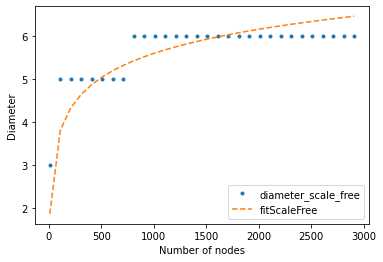

In [13]:
def sqrt_law(x, a):
    return a*np.sqrt(x)

def log_law(x, a):
    return a*np.log(x)

poptSF, pcovSF = curve_fit(log_law, N, diameter_scalefree)
# poptR, pcovR = curve_fit(log_law, N, diameter_random)
# random_fit = np.polyfit(N, max_degree_random, 1)

perrSF = np.sqrt(np.diag(pcovSF))
# perrR = np.sqrt(np.diag(pcovR))

print("Scale free fit parameters:", poptSF, "∓", perrSF)
# print("Random fit parameters:", poptR, "∓", perrR)
# print("Second random fit parameters:", random_fit)

# fitRandom2 = [random_fit[0]*n + random_fit[1] for n in N]
fitScale = log_law(N, *poptSF)
# fitRandom = log_law(N, *poptR)

fig, ax = plt.subplots()
    
ax.plot(N, diameter_scalefree, '.', label = 'diameter_scale_free')
# ax.plot(N, max_degree_random, '.', label = 'max_degree_random')

# ax.plot(N, fitRandom, '--', label = 'fitRandom')
# ax.plot(N, fitRandom2, '--', label = 'fitRandom')
ax.plot(N, fitScale, '--', label = 'fitScaleFree')

ax.set_xlabel("Number of nodes")
ax.set_ylabel("Diameter") 
ax.legend()

plt.show()